In [2]:
using Pkg; Pkg.activate(".")

  Activating project at `~/experiments/cf`


In [3]:
using Revise
includet("mixing_length.jl")

[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (4), incompatible header (10), dep missing source (2))
[ Info: Precompiling RecursiveArrayToolsStructArraysExt [07510ace-05c5-59ac-8535-cc0df8d4a157] (cache misses: wrong dep version loaded (8), incompatible header (10))
[ Info: Precompiling AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6] 
┌ Info: Skipping precompilation due to precompilable error. Importing AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
[ Info: Precompiling SciMLBaseMakieExt [565f26a4-c902-5eae-92ad-e10714a9d9de] (cache misses: wrong dep version loaded (8), incompatible header (10))
[ Info: Precompiling DiffEqBaseUnitfulExt [aeb06bb4-539b-5a1b-8332-034ed9f8ca66] (cache misses: wrong dep version loaded (6), incompatible header (12))
[ Info: Preco

In [6]:
mix_len, mix_len_no_z = compute_mixing_length(ds_profiles, ds_timeseries, params)

(ClimaAtmos.MixingLength{Float32}[ClimaAtmos.MixingLength{Float32}(0.027332691f0, 8.629264f0, 0.0f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.838308f0, 8.807261f0, 64.61138f0, 20.0f0) … ClimaAtmos.MixingLength{Float32}(8.383935f0, 8.365395f0, 69.21188f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.368324f0, 8.350131f0, 69.2388f0, 20.0f0); ClimaAtmos.MixingLength{Float32}(3.733875f-5, 19.769424f0, 0.0f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 20.235554f0, 57.838207f0, 40.0f0) … ClimaAtmos.MixingLength{Float32}(19.208103f0, 19.077742f0, 64.05938f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(19.165094f0, 19.037245f0, 64.67273f0, 40.0f0); … ; ClimaAtmos.MixingLength{Float32}(1.1920929f-7, 5947.598f0, 0.0f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 6111.6177f0, 108.38234f0, 3980.0f0) … ClimaAtmos.MixingLength{Float32}(20.0f0, 5703.0127f0, 108.525955f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 5688.472f0, 108.52624f0, 3980.0f0); ClimaAtmos.MixingLength{Float32}(1

In [20]:
# compute gradients
z = ds_profiles["z"][:]
thetali_gradient = compute_vertical_gradient(ds_profiles["thetali_mean"][:, :]', z)'
qt_gradient = compute_vertical_gradient(ds_profiles["qt_mean"][:, :]', z)';

In [16]:
# compute the normalization lengths
q_lengthscale = find_q_lengthscale(params, ds_profiles)

p_example = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][:, :] .* ds_profiles["temperature_mean"][:, :]
q_tot_example = ds_profiles["qt_mean"][:, :]
θ_lengthscale = find_thetali_lengthscale.(CAP.thermodynamics_params(params), p_example, q_tot_example);

200×865 Matrix{Float64}:
 285.684  286.28   286.506  286.633  …  285.942  285.949  285.974  285.962
 285.753  286.146  286.387  286.526     285.745  285.752  285.785  285.771
 285.833  286.1    286.338  286.48      285.675  285.673  285.709  285.693
 285.925  286.077  286.293  286.439     285.672  285.648  285.685  285.676
 286.031  286.101  286.269  286.417     285.733  285.691  285.724  285.724
 286.147  286.169  286.272  286.414  …  285.825  285.774  285.8    285.805
 286.27   286.268  286.311  286.431     285.934  285.877  285.894  285.904
 286.396  286.383  286.389  286.469     286.048  285.992  285.997  286.012
 286.522  286.506  286.495  286.533     286.163  286.111  286.107  286.123
 286.649  286.632  286.616  286.623     286.276  286.23   286.221  286.235
 286.777  286.759  286.742  286.733  …  286.387  286.348  286.338  286.347
 286.905  286.886  286.867  286.851     286.495  286.466  286.456  286.458
 287.033  287.012  286.99   286.97      286.601  286.583  286.572  286.567


In [ ]:
size(thetali_gradient)
size(mix_len_no_z)


(200, 865)

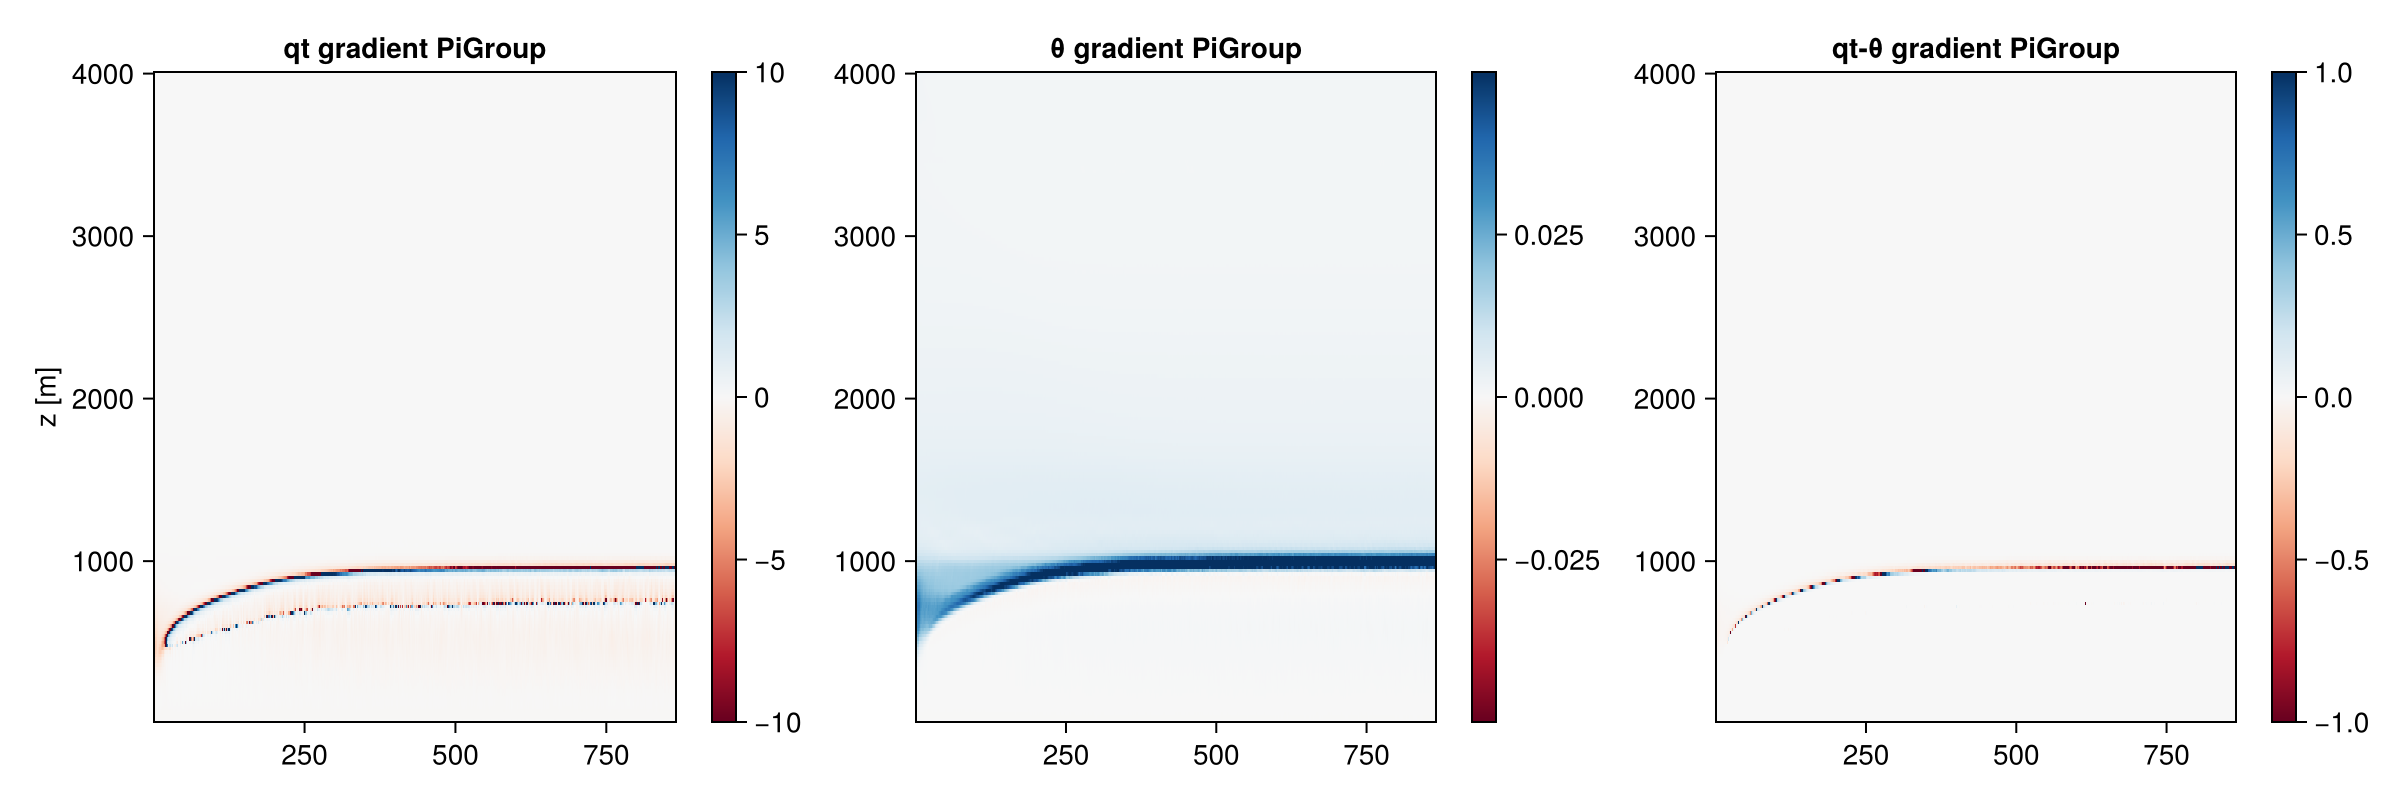

In [41]:
# assemble the predictors
gr1 = qt_gradient .* mix_len_no_z ./ q_lengthscale
gr2 = thetali_gradient .* mix_len_no_z ./ θ_lengthscale
gr3 = qt_gradient .* thetali_gradient .* mix_len_no_z .^2 ./ (q_lengthscale .* θ_lengthscale)

fig = Figure(size=(1200, 400))
ax1 = Axis(fig[1, 1], ylabel="z [m]", title="qt gradient PiGroup")
ax2 = Axis(fig[1, 3], title="θ gradient PiGroup")
ax3 = Axis(fig[1, 5], title="qt-θ gradient PiGroup")

# Plot heatmaps
t = 1:size(gr1, 2)
hm1 = heatmap!(ax1, t, z, gr1', colormap=:RdBu, colorrange = (-10, 10))
Colorbar(fig[1, 2], hm1)
hm2 = heatmap!(ax2, t, z, gr2', colormap=:RdBu, colorrange = (-.05, .05))
Colorbar(fig[1, 4], hm2)
hm3 = heatmap!(ax3, t, z, gr3', colormap=:RdBu, colorrange = (-1, 1))
Colorbar(fig[1, 6], hm3)

# Set y-axis to show height
# for ax in [ax1, ax2, ax3]
#     ax.yticks = (1:40:200, string.(round.(Int, z[1:40:200])))
# end

fig
